# Multi-slice alignment in the mouse brain coronal dataset (representation learning process)

We present our evaluation source code of the representation learning process of the mouse brain coronal dataset in this section.

## Data Preparation

First, we obtain the adata fromat data by `st_datasets`.

In [1]:
import scanpy as sc

import st_datasets as stds
from train_integrate import train_integration
from stMSA.utils import get_palette

data_urls = [
    'https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000218/stomics/STSP0006534/GSM6704280_ZT4_F_Saline_filtered_feature_bc_matrix_processed.h5ad',
    'https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000218/stomics/STSP0006535/GSM6704281_ZT4_F_RHY_filtered_feature_bc_matrix_processed.h5ad',
    'https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000218/stomics/STSP0006536/GSM6704282_ZT14_F_Saline_filtered_feature_bc_matrix_processed.h5ad',
    'https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000218/stomics/STSP0006537/GSM6704283_ZT14_F_RHY_filtered_feature_bc_matrix_processed.h5ad',
    'https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000218/stomics/STSP0006538/GSM6704284_ZT4_M_Saline_filtered_feature_bc_matrix_processed.h5ad',
    'https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000218/stomics/STSP0006539/GSM6704285_ZT4_M_RHY_filtered_feature_bc_matrix_processed.h5ad',
    'https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000218/stomics/STSP0006540/GSM6704286_ZT14_M_Saline_filtered_feature_bc_matrix_processed.h5ad',
]

adata_list = [stds.get_data(stds.get_outside_data, preprocess=False, url=url)[0] for url in data_urls]
adatas = sc.concat(adata_list, label='batch')
adatas = adatas[:, adata_list[-1].var['highly_variable']]

>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (2522, 32285), cluster: None.(0.665s)
>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (2831, 32285), cluster: None.(0.605s)
>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (2752, 32285), cluster: None.(0.651s)
>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (2816, 32285), cluster: None.(0.582s)
>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (2108, 32285), cluster: None.(0.430s)
>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (2639, 32285), cluster: None.(0.681s)
>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (2741, 32285), cluster: None.(0.507s)


## Train stMSA

Then, we can learn the latent representation by stMSA.
- We saved the adata result for later alignment process.

In [2]:
adatas = train_integration(adatas, radius=75)
adatas.write('mouse_brain_coronal_7_slices.h5ad')

>>> INFO: Generate 17220 edges, 5.828 edges per spot.(0.012s)
>>> INFO: Generate 19353 edges, 5.836 edges per spot.(0.012s)
>>> INFO: Generate 18770 edges, 5.820 edges per spot.(0.161s)
>>> INFO: Generate 19264 edges, 5.841 edges per spot.(0.011s)
>>> INFO: Generate 14292 edges, 5.780 edges per spot.(0.009s)


>>> INFO: Generate 17997 edges, 5.820 edges per spot.(0.011s)
>>> INFO: Generate 18691 edges, 5.819 edges per spot.(0.011s)
>>> INFO: Finish generate precluster embedding(6.447s)!


  0%|          | 1/500 [00:06<57:17,  6.89s/it]

>>> INFO: Finish finding mmn pairs, find 2768952 mnn node pairs(5.943s)!


 20%|██        | 100/500 [00:37<02:03,  3.24it/s]

>>> INFO: Finish finding mmn pairs, find 3892088 mnn node pairs(6.479s)!


 40%|████      | 200/500 [01:17<01:40,  2.98it/s]

>>> INFO: Finish finding mmn pairs, find 4097555 mnn node pairs(6.564s)!


 60%|██████    | 300/500 [01:58<01:07,  2.95it/s]

>>> INFO: Finish finding mmn pairs, find 4162514 mnn node pairs(6.471s)!


 80%|████████  | 400/500 [02:38<00:34,  2.93it/s]

>>> INFO: Finish finding mmn pairs, find 4192257 mnn node pairs(6.471s)!


100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


## Clustering

Next, we do the clustering by the latent representation of stMSA to find the landmark domain.

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In value[[3L]](cond) :
R[write to console]: 
 
R[write to console]:  "getThreads" not available for .C() for package "RevoUtilsMath"

R[write to console]: 2: 
R[write to console]: In value[[3L]](cond) :
R[write to console]: 
 
R[write to console]:  "getThreads" not available for .C() for package "RevoUtilsMath"

R[write to console]: 3: 
R[write to console]: In value[[3L]](cond) :
R[write to console]: 
 
R[write to console]:  "getThreads" not available for .C() for package "RevoUtilsMath"

R[write to console]: Package 'mclust' version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



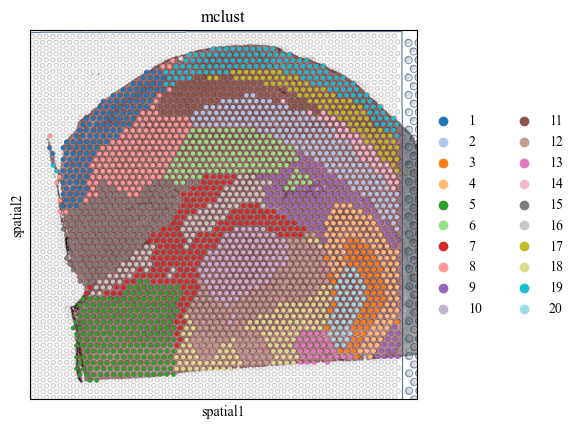

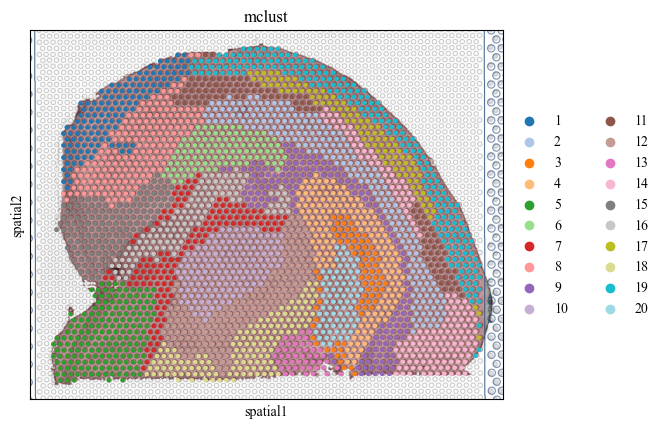

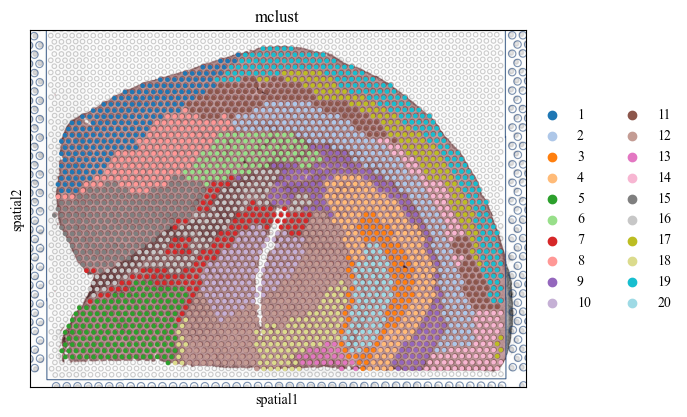

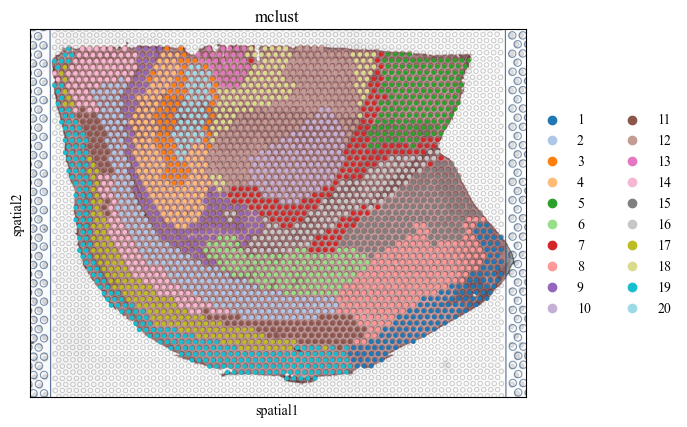

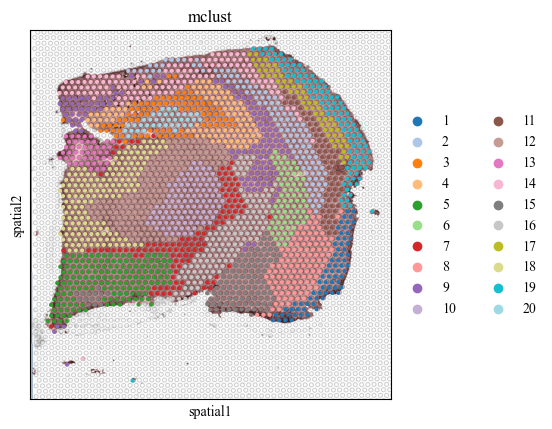

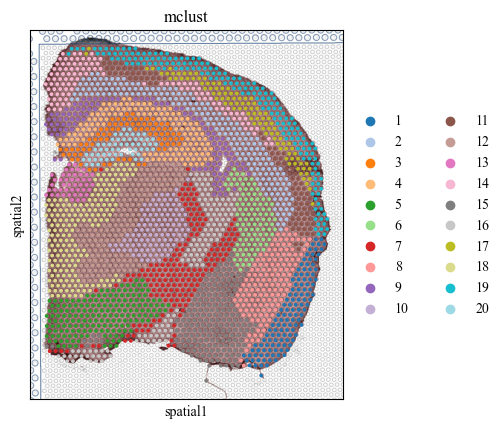

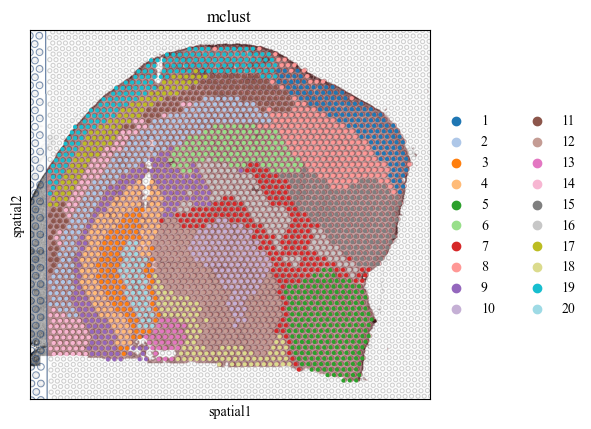

In [3]:
adatas = stds.cl.mclust_R(adatas, num_cluster=20, used_obsm='embedding')

palette = get_palette(set(adatas.obs['mclust']))
for i in range(7):
    adata_list[i].obs['mclust'] = adatas[str(i) == adatas.obs['batch']].obs['mclust']
    sc.pl.spatial(adata_list[i], color=['mclust'], palette=palette, save=f'cluster_img_{i}.pdf')

## Visualization of the landmark doamin

We determine to use the domain 4 (the pyramidal layer in the hippocampus) as the landmark domain.

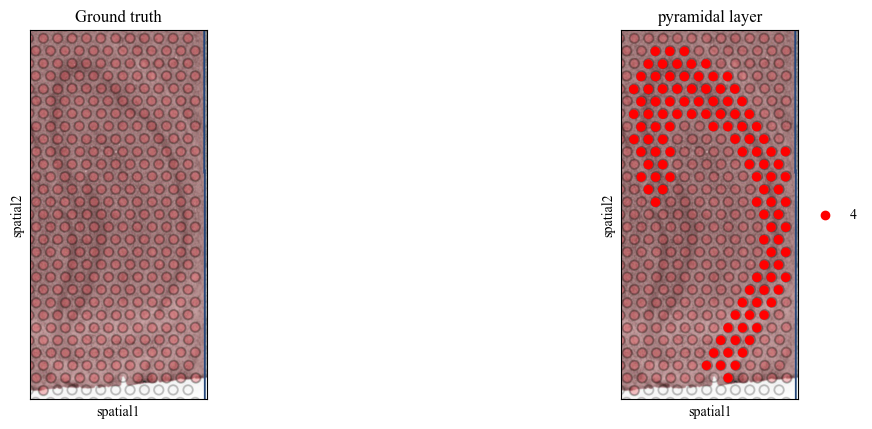

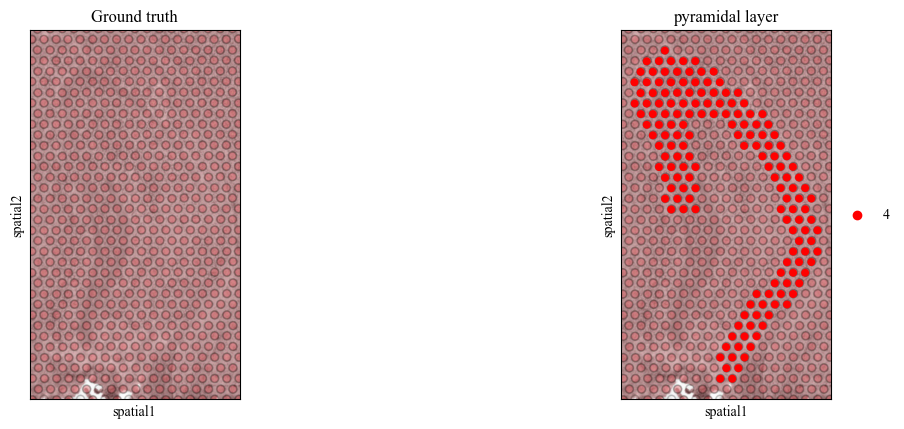

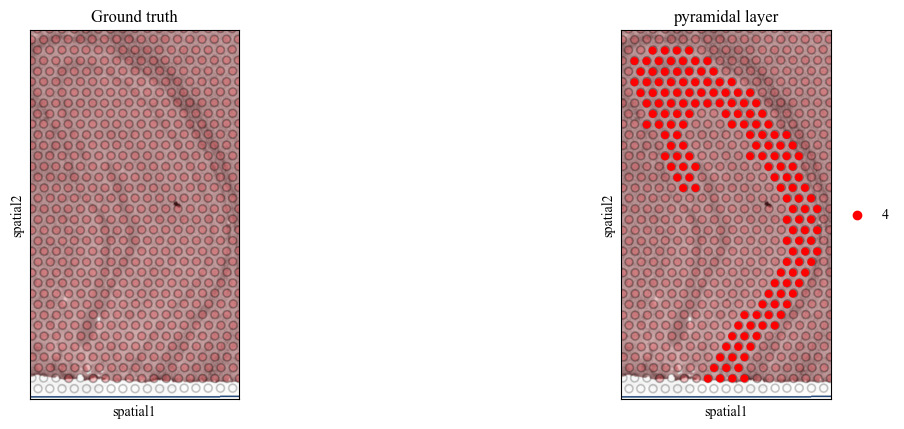

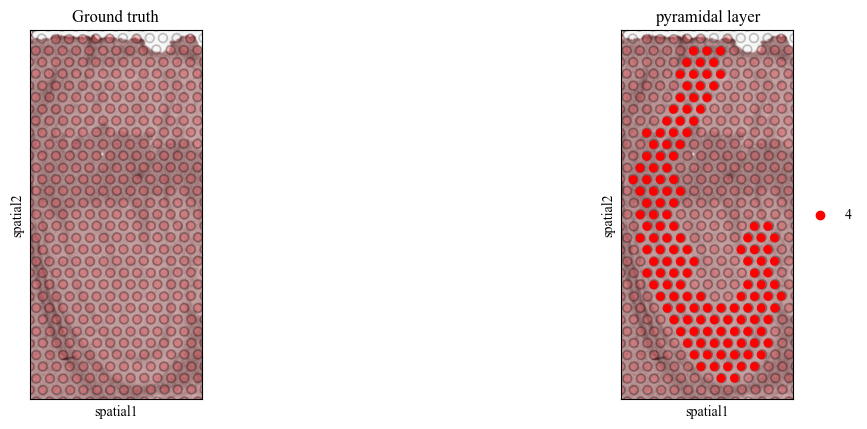

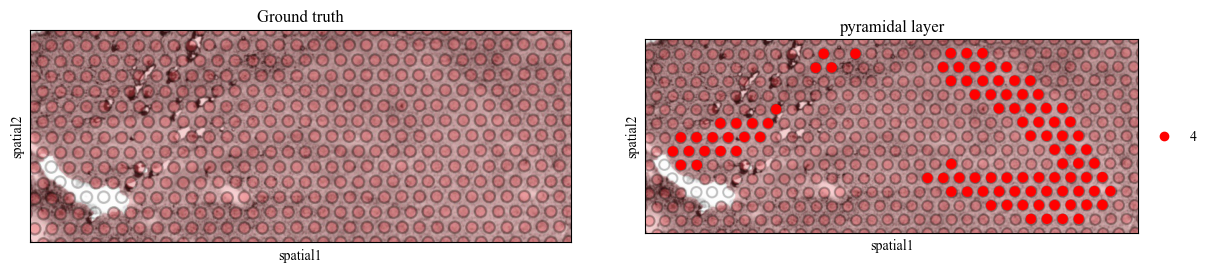

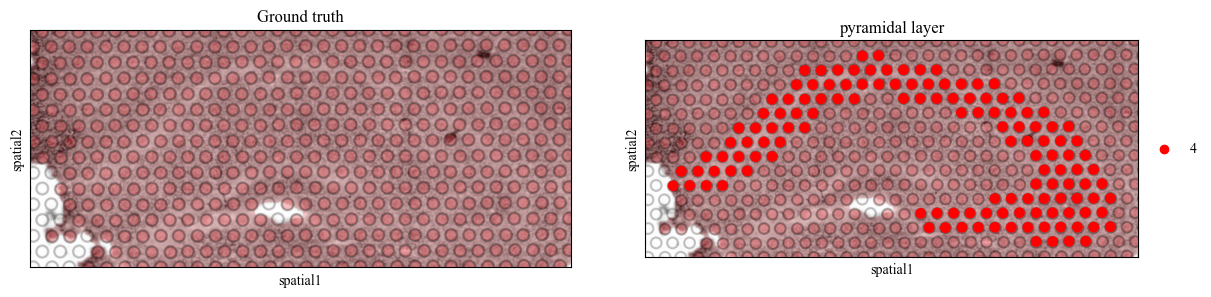

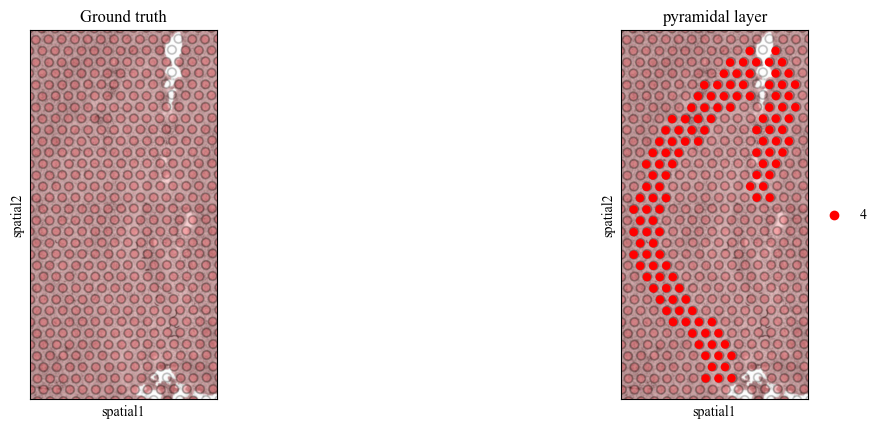

In [4]:
pyramidal_label_id = 4
for i in range(7):
    adata = adata_list[i][pyramidal_label_id == adata_list[i].obs['mclust']]
    sc.pl.spatial(adata, color=[None, 'mclust'], title=['Ground truth', 'pyramidal layer'], palette={pyramidal_label_id: 'red'}, save=f'pyramidal_img_{i}.pdf')